In [1]:
num_iters = 4000
env_num = 5
spec_num = 0
use_gpu = True

In [2]:
from conformal.all_paths_conformal_pred import all_paths_conformal_pred
from conformal.bucketed_conformal_pred import bucketed_conformal_pred
from conformal.nonconformity_score_graph import DIRLCumRewardScoreGraph, DIRLTimeTakenScoreGraph
from spectrl.hierarchy.construction import adj_list_from_task_graph, automaton_graph_from_spec
from spectrl.hierarchy.reachability import HierarchicalPolicy, ConstrainedEnv
from spectrl.main.spec_compiler import ev, seq, choose, alw
from spectrl.rl.ddpg.ddpg import DDPGParams
from spectrl.util.io import parse_command_line_options, save_log_info, save_object
from spectrl.util.rl import print_performance, get_rollout
from spectrl.rl.ars import HyperParams

from spectrl.examples.rooms_envs import (
    GRID_PARAMS_LIST,
    MAX_TIMESTEPS,
    START_ROOM,
    FINAL_ROOM,
)
from spectrl.envs.rooms import RoomsEnv

import os

In [ ]:
render = False
folder = ''
itno = -1

log_info = []

grid_params = GRID_PARAMS_LIST[env_num]

# hyperparams = HyperParams(30, num_iters, 30, 15, 0.05, 0.3, 0.15)

print(
    "\n**** Learning Policy for Spec #{} in Env #{} ****".format(
        spec_num, env_num
    )
)

# Step 1: initialize system environment
system = RoomsEnv(grid_params, START_ROOM[env_num], FINAL_ROOM[env_num])

state_dim = system.observation_space.shape[0]
action_dim = system.action_space.shape[0]
action_bound = system.action_space.high
hyperparams = DDPGParams(state_dim, action_dim, action_bound,
                            minibatch_size=256, num_episodes=num_iters,
                            discount=0.95, actor_hidden_dim=256,
                            critic_hidden_dim=256, epsilon_decay=3e-6,
                            decay_function='linear', steps_per_update=100,
                            gradients_per_update=100, buffer_size=200000,
                            sigma=0.15, epsilon_min=0.3, target_noise=0.0003,
                            target_clip=0.003, warmup=1000)

# Step 4: List of specs.
if env_num == 2 or env_num == 5:
    bottomright = (0, 2)
    topleft = (2, 0)
if env_num == 3 or env_num == 4:
    bottomright = (0, 3)
    topleft = (3, 0)

spec0 = seq(
    choose(
        alw(grid_params.avoid_center_without_scaling((1, 0), 7.5), ev(grid_params.in_room_without_scaling(topleft))),
        alw(grid_params.avoid_center_without_scaling((0, 1), 10), ev(grid_params.in_room_without_scaling(bottomright)))
    ),
    ev(grid_params.in_room_without_scaling(FINAL_ROOM[env_num]))
)
spec1 = seq(
    alw(grid_params.avoid_center_without_scaling((1, 0), 7.5), ev(grid_params.in_room_without_scaling(topleft))),
    ev(grid_params.in_room_without_scaling(FINAL_ROOM[env_num]))
)
spec2 = alw(grid_params.avoid_center_without_scaling((1, 0), 7.5), ev(grid_params.in_room_without_scaling(topleft)))
spec3 = seq(
    ev(grid_params.in_room_without_scaling(bottomright)),
    ev(grid_params.in_room_without_scaling(FINAL_ROOM[env_num]))
)

specs = [spec0, spec1, spec2, spec3]

# Step 3: construct abstract reachability graph
_, abstract_reach = automaton_graph_from_spec(specs[spec_num])
print("\n**** Abstract Graph ****")
abstract_reach.pretty_print()

# Step 5: Learn policy
path_policies = abstract_reach.learn_all_paths(
    system,
    hyperparams,
    res_model=None,
    max_steps=40,
    render=render,
    neg_inf=-100,
    safety_penalty=-1,
    num_samples=500,
    use_gpu=use_gpu,
    algo="ddpg",
    alpha=0,
)

adj_list = adj_list_from_task_graph(abstract_reach.abstract_graph)
terminal_vertices = [i for i in range(len(adj_list)) if i in adj_list[i]]

import dill as pickle

with open("conformal_experiments_data/9rooms-counterexample-policies/path_policies.pkl", "wb") as f:
    pickle.dump(path_policies, f)

with open("conformal_experiments_data/9rooms-counterexample-policies/adj_list.pkl", "wb") as f:
    pickle.dump(adj_list, f)

with open("conformal_experiments_data/9rooms-counterexample-policies/terminal_vertices.pkl", "wb") as f:
    pickle.dump(terminal_vertices, f)


In [3]:
from conformal.all_paths_conformal_pred import all_paths_conformal_pred
from conformal.bucketed_conformal_pred import bucketed_conformal_pred
from conformal.calculate_coverage import calculate_coverage
from conformal.nonconformity_score_graph import DIRLCumRewardScoreGraph

import dill as pickle
import json

with open("conformal_experiments_data/9rooms-counterexample-policies/path_policies.pkl", "rb") as f:
    path_policies = pickle.load(f)

with open("conformal_experiments_data/9rooms-counterexample-policies/adj_list.pkl", "rb") as f:
    adj_list = pickle.load(f)

with open("conformal_experiments_data/9rooms-counterexample-policies/terminal_vertices.pkl", "rb") as f:
    terminal_vertices = pickle.load(f)

cum_reward_score_graph = DIRLCumRewardScoreGraph(adj_list, path_policies, cum_reward_type="cum_safety_reach_reward")
n_samples = 1000
n_samples_coverage = 1000
es = [0.1]
total_buckets = [100]

data_cum_reward = dict()
data_cum_reward["metadata"] = {"es": es, "total_buckets": total_buckets, "scores": "cum-reward", "env": "9-rooms", "spec": spec_num, "n_samples": n_samples}

for e in es:
    e_data = dict()
    for buckets in total_buckets:
        bucket_data = dict()
        vbs = bucketed_conformal_pred(cum_reward_score_graph, e, buckets, n_samples)
        min_path, min_path_scores = all_paths_conformal_pred(cum_reward_score_graph, e, n_samples)
        vb = vbs.buckets[(terminal_vertices[0], buckets)]

        bucket_data["bucketed"] = {"path": vb.path, 
                                   "path_buckets": vb.path_buckets, 
                                   "path_score_quantiles": vb.path_score_quantiles, 
                                   "max_path_score_quantile": max(vb.path_score_quantiles)}
        bucket_data["all-paths"] = {"path": min_path, "min_path_scores": min_path_scores, "max_min_path_scores": max(min_path_scores)}

        bucket_data["bucketed-coverage"] = calculate_coverage(
            cum_reward_score_graph, vb.path, vb.path_score_quantiles, n_samples_coverage
        )
        bucket_data["all-paths-coverage"] = calculate_coverage(
            cum_reward_score_graph, 
            min_path, 
            [max(min_path_scores) for _ in range(len(min_path)-1)], 
            n_samples_coverage,
        )
        e_data[buckets] = bucket_data
    data_cum_reward[str(e)] = e_data

# Convert the Python object to a JSON string
json_data = json.dumps(data_cum_reward, indent=2)

# Store the JSON string in a file
with open("conformal_experiments_data/9rooms-counterexample-cum-reward.json", "w") as json_file:
    json_file.write(json_data)


In [5]:
trajectories_scores1 = cum_reward_score_graph.sample_full_path_cached([0, 1, 3], n_samples)
trajectories_scores2 = cum_reward_score_graph.sample_full_path_cached([0, 2, 3], n_samples)

# trajectories_scores1 = cum_reward_score_graph.sample_full_path_cached([0, 1], n_samples)
# trajectories_scores2 = cum_reward_score_graph.sample_full_path_cached([0, 1], n_samples)

successful_trajs1, successful_trajs2 = 0, 0

for i in range(n_samples):
    if all(trajectories_scores1[i][j] <= 0 for j in range(2)):
        successful_trajs1 += 1
    if all(trajectories_scores2[i][j] <= 0 for j in range(2)):
        successful_trajs2 += 1

print("path 1 success prob " + str(successful_trajs1/n_samples))
print("path 2 success prob " + str(successful_trajs2/n_samples))

path 1 success prob 1.0
path 2 success prob 1.0


In [5]:
print(trajectories_scores1)

[[-0.6979478555183647, -8.863695029809369], [-0.7051724464021039, -9.724520379431466], [-0.6937699260162136, -9.232812106273707], [-0.709320089673104, -9.422221433218938], [-0.6743563597934479, -9.540994893227806], [-0.6347835043082641, -9.281817708619924], [-0.6440857131738902, -9.125780244890256], [-0.6500481475777771, -9.526985417703285], [-0.6429741317860169, -9.107718526621055], [-0.6683290507864954, -9.004698672934195], [-0.687899579566059, -8.940383696329507], [-0.6477779820371068, -9.67193073879906], [-0.6370523554163072, -8.781508616967907], [-0.70446343678418, -9.362214419682845], [-0.6459426917452205, -9.261206042691787], [-0.6673730952435011, -8.97575737028061], [-0.7056073284781701, -9.301416231660431], [-0.6391419309823694, -9.580555988934014], [-0.6848754106255499, -8.899385817324232], [-0.6626549181020054, -9.29877906128762], [19.8602840242822, -9.22751805451009], [-0.7103863509086441, -9.4934802951743], [19.730334969411746, -9.421835497049406], [-0.6464454809853932, -9

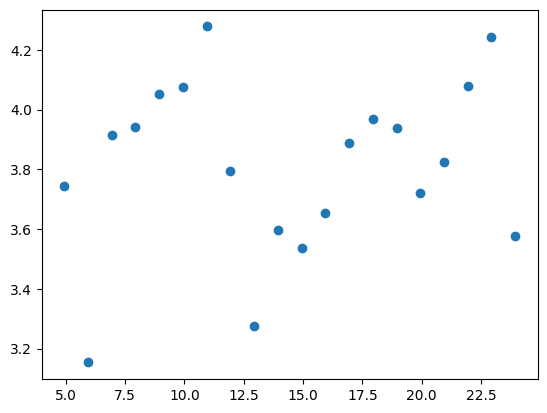

In [14]:
import matplotlib.pyplot as plt
import numpy as np

pp = cum_reward_score_graph.path_policies.get_vertex_path_policy([0])
sarss = get_rollout(
    pp.reach_envs[1],
    pp.policies[1],
    False,
    init_state=None
)
states = [state for state, _, _, _ in sarss] + [sarss[-1][-1]]
x_coords = [state[0] for state in states]
y_coords = [state[1] for state in states]

# Plot the points
plt.scatter(y_coords, x_coords)

[8.951920929984633, 7.954876804469033, 6.961256615436351, 5.970793757694742, 4.973419671880259, 3.974164561890137, 2.9745106095520564, 1.974657679830174, 0.9746586994152873, -0.025341300032347525, 0.4920079666983836, 1.4920079666983836, 2.4920079666983836, 3.4920079666983836, 4.492007966698384, 5.492007966698384, 6.492007966698384, 7.492007966698384, 8.492007966698383, 9.492007966698383, 10.492007966698383, 11.492007966698383, 12.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383, 13.492007966698383]


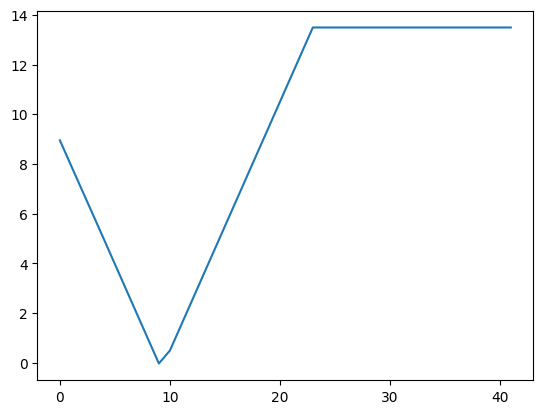

In [ ]:
reach_env = pp.reach_envs[1]
safety_rewards = []
for s in states:
    safety_rewards.append(reach_env.constraints[0](s, None))

print(safety_rewards)
plt.plot(safety_rewards)